# Using cellproject to assymetrically integrate Smart-Seq2 and 10x data

Author: Iwo Kucinski (https://github.com/Iwo-K/)

This notebook shows a practical use of cellproject and it operates downstream of other batch correction methods. We will try to solve a common problem of integrating scRNA-Seq data generated with different technologies, here Smart-Seq2 and 10x. We are aiming do do this in an **asymmetric** fashion ie. without modifying the reference landscape. This is useful if we are re-using a previously established landscape or we simply don't want to redo all the figures.

## Setup

In [81]:
import scanpy as sc
import cellproject as cp
import scanpy.external as sce

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

We will use two datasets - reference (10x) and target (Smart-Seq2:
- **ref** - a random subset of 10x data from Dahlin et al. 2018. It contains a mixture of heamatopoietic stem and progenitors (from the Lin-, cKit+ gate) and should contain all cells populations found in the target dataset.
- **target** - a subset of Smart-Seq2 data from Nestorowa et al. 2016, which contains heamatopoietic stem cells (HSCs), lymphoid-primed multipotent progeniors (LMPP) and granulocyte-macrophage progenitors (GMPs)

As the Smart-Seq2 contains immunophenotypically defined population (which have been verified functionally) we would like to find their counterparts within the 10x landscape.

In [83]:
ref = sc.read('./data/LKdata_logn_smallexample.h5ad')
target = sc.read('./data/sfdata_logn_smallexample.h5ad')

#Unify the genes
ref = ref[:, ref.var.index[ref.var.index.isin(target.var.index)]].copy()
target = target[:, ref.var.index].copy()

#Safely storing log-normalised values for later use
ref.layers['logn'] = ref.X.copy()
target.layers['logn'] = target.X.copy()

## Simple symmetric integration

First we will see what happens if we combine the two datasets and generate a common landscape with no batch correction. Throughout this notebook we will be using a fairly standard processing strategy: data scaling (zero-centered variables) -> PCA -> nearest neighbors -> leiden clustering + UMAP

In [84]:
comb = ref.concatenate(target, batch_key='data_type', batch_categories=['10x', 'SS2'], index_unique=None)
comb.var['highly_variable'] = comb.var['highly_variable-10x']

#Running the standard processing steps to generate a common landscape
sc.pp.scale(comb)
sc.tl.pca(comb, n_comps=20)
sc.pp.neighbors(comb, n_neighbors=7)
umap_com_cor = cp.quick_umap(comb)

... storing 'phase' as categorical
... storing 'leiden' as categorical
... storing 'anno' as categorical
... storing 'celltype' as categorical
... storing 'celltype_e' as categorical
... storing 'cellanno' as categorical


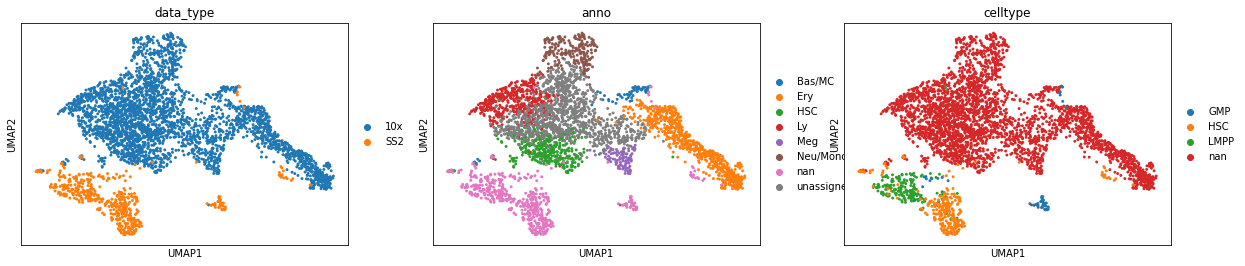

In [85]:
# Now we can plot the combined landscape. Smart-Seq2 contains experimentally defined cell types (`celltype`), in 10x we provide a rough lineage annotation (`anno`) based on clustering and selected marker genes.
sc.pl.umap(comb, color=['data_type', 'anno', 'celltype'])

As expected the Smart-Seq2 and 10x datasets show a very strong batch effect, with almost no overlap.

## Simple asymmetric integration
In this section we will show how cellproject reduces batch effects while leaving reference data unmodified. First, we will need to create the reference 10x landscape, processing steps as described above.

Note: we use the quick_umap function to calculate UMAP coordinates and store the UMAP object to enable fitting data afterwards.

/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


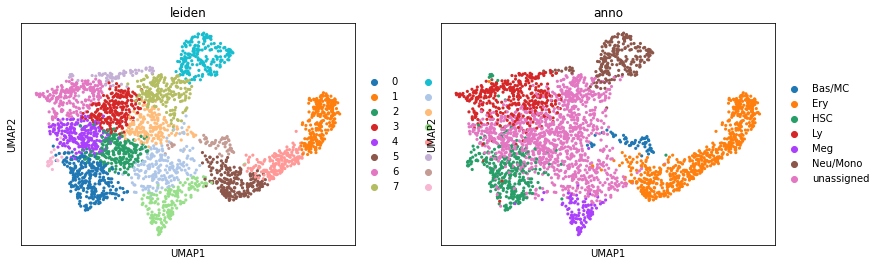

In [86]:
sc.pp.scale(ref)
sc.tl.pca(ref, n_comps=20)
sc.pp.neighbors(ref, n_neighbors=7)
sc.tl.leiden(ref)
umap_ref = cp.quick_umap(ref)

#Plotting reference landscape.
sc.pl.umap(ref, color=['leiden', 'anno'])

To merge the target data into reference we need to transform target expression data to fit into reference principal component (PC) space. `project_cells` uses the reference rotation matrix to achieve this and asymmetrically integrates target data into the reference landscape as follows:
- fits target expression data into the reference PC space (optional, ON by default)
- identifies nearest neighbors between the datasets
- transfers cells annotation (categorical or numeric)
- fits target data into the reference UMAP (optional, if a UMAP object is provided)

`project_cells` by default (`scale_data=True`) automatically handles data scaling to match the reference (see notebook data_scaling.ipynb why this is important), so we provide scaled reference data and log-normalised counts for the target data.

In [87]:
cp.project_cells(target, ref,
                       obs_columns=['leiden', 'anno'],
                       k=10,
                       pca_n_components=None,
                       scale_data=True,
                       umap_ref=umap_ref)

Running a common scaling for target and reference data
Fitting target data (.X) into reference PC space
Using existing PCA rotation in .varm["PCs"]
Using the provided UMAP reference to fit new data


... storing 'ref_leiden' as categorical
... storing 'ref_anno' as categorical


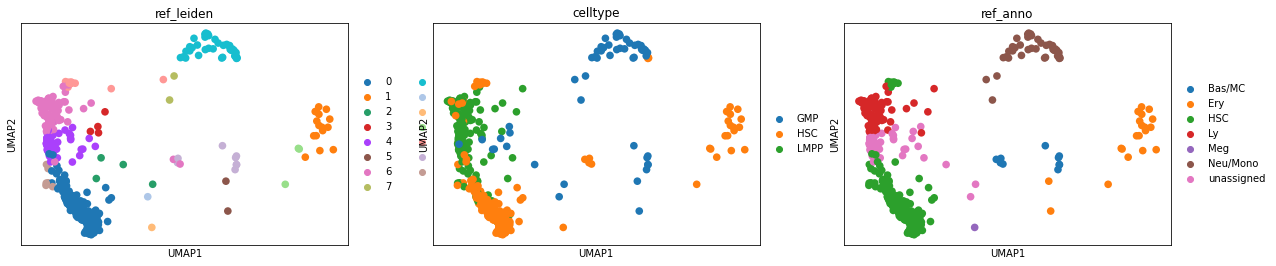

... storing 'phase' as categorical
... storing 'leiden' as categorical
... storing 'anno' as categorical
... storing 'celltype' as categorical
... storing 'celltype_e' as categorical
... storing 'cellanno' as categorical
... storing 'ref_leiden' as categorical
... storing 'ref_anno' as categorical


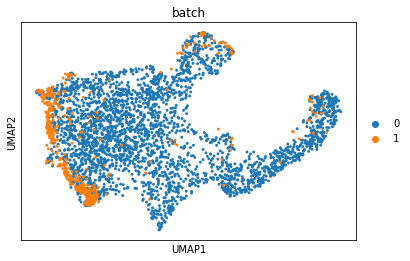

In [88]:
#Plotting the transferred annotation
sc.pl.umap(target, color=['ref_leiden', 'celltype', 'ref_anno'])

#Superimposing the reference and target UMAP coordinates
comb = ref.concatenate(target)
sc.pl.umap(comb, color=['batch'])

Using this simple approach the Smart-Seq2 data is merged into the 10x landscape with main celltypes approximately in the correct areas. However, we can still observe some residual batch effect as the HSC and LMPP cells seemed to be squashed on one side of the UMAP projection. 

Below we inspect, which cells in the reference landscape are nearest neighbors of the target data cell types. Cellproject stores this information as a sparse matrix target cells x reference cells in the target data in the `.uns['cross-nn']` attribute.

/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


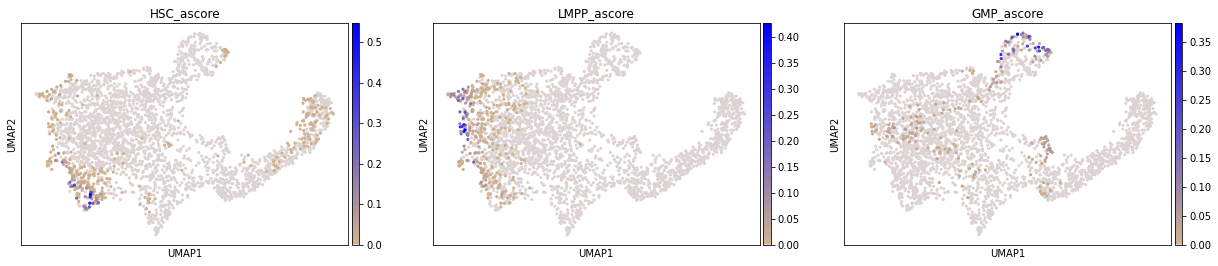

In [89]:
toplot = []
for i in target.obs.celltype.unique():
    x = target[target.obs.index[target.obs.celltype == i],:].copy()
    nn = x.uns['cross_nn'][target.obs.celltype == i,:]
    nn = nn > 0
    ascore = nn.sum(axis = 0).A1 / nn.shape[0]
    ref.obs[i + '_ascore'] = ascore
    toplot.append(i + '_ascore')
    
from matplotlib.colors import LinearSegmentedColormap
cmap2 = LinearSegmentedColormap.from_list('mycmap', [(0, '#DDD3D3'),
                                                    (0.001, 'tan'),
                                                    (1, 'blue')])
sc.pl.umap(ref, color=toplot, cmap=cmap2)

Indeed the HSC and LMPP nearest neighbors are grouped against a side of the UMAP projection.
`project_cells` can overcome moderate batch effects, but other methods may be required to remove stronger effects, such as the one presented above. Fortunately, cellproject is designed to assists with asymmetric data integration downstream of other batch correction methods, which will be discussed below.

## Batch correction + symmetric integration

To minimize the batch effect we will try using another batch correction method. There are many such methods integrated into the scanpy ecosystem (e.g. Combat, Scanorama, BBKNN, Harmony, mnnCorrect). In this particular case we found that Seurat's method performed very well for Smart-Seq2 and 10x data integration. We will use this method to obtain a joint target/ref landscape. We will first run a symmetric integration between the target and ref data to examine the method performance.

For convenience we provide a python wrapper around Seurat `FindIntegrationAnchors` and `IntegrateData` functions. It expects log-normalised data combined into a single AnnData object and returns corrected expression data.

In [90]:
#Storing scaled values and going back to log-normalised values
ref.layers['scaled'] = ref.X.copy()
target.layers['scaled'] = target.X.copy()
ref.X = ref.layers['logn'].copy()
target.X = target.layers['logn'].copy()

#Combining data
comb = ref.concatenate(target, batch_key='data_type', batch_categories=['10x', 'SS2'], index_unique=None)
comb.var['highly_variable'] = comb.var['highly_variable-10x']

#Running the batch correction
comb_cor = cp.run_SeuratCCA(comb)

... storing 'phase' as categorical
... storing 'leiden' as categorical
... storing 'anno' as categorical
... storing 'celltype' as categorical
... storing 'celltype_e' as categorical
... storing 'cellanno' as categorical
... storing 'ref_leiden' as categorical
... storing 'ref_anno' as categorical


Storing data in "./.anndata_transfers_vvl5u6ps" temporary directory


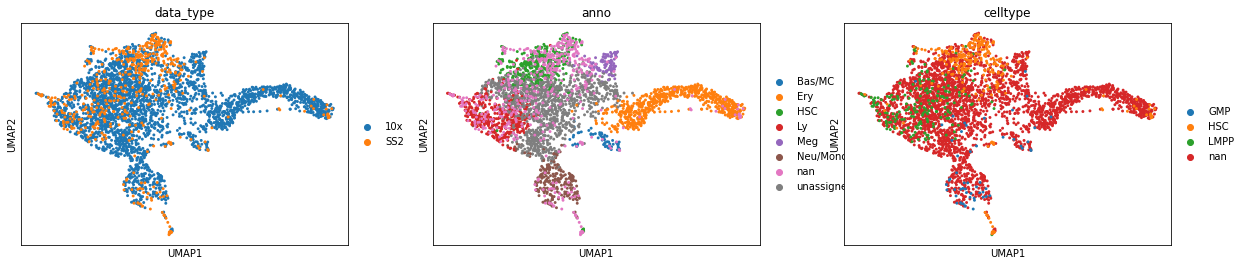

In [91]:
#We will need unscaled data later
comb_cor_unscaled = comb_cor.copy()

#Generating a common landscape
sc.pp.scale(comb_cor)
sc.tl.pca(comb_cor, n_comps=20)
sc.pp.neighbors(comb_cor, n_neighbors=7)
umap_comb_cor = cp.quick_umap(comb_cor)
sc.pl.umap(comb_cor, color=['data_type', 'anno', 'celltype'])

With symmetric integration we have new UMAP coordinates but we haven't transferred any cell annotation. `project_cells` will again be useful here. We simply split the corrected dataset and run the `project_cells` using the common PC space. In this case we don't want to modify the PC coordinates or scale the data, so we set `fit_pca` and `scale_data` to `False`.

/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


No valid UMAP object provided, UMAP parameters left unmodified


... storing 'ref_anno' as categorical


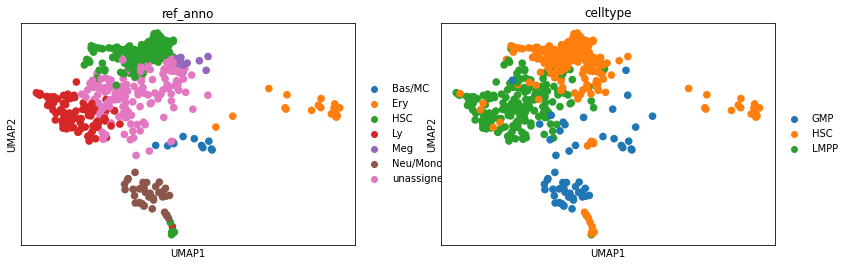

In [92]:
#Splitting combined dataset
target2 = comb_cor[comb_cor.obs.data_type == 'SS2', :].copy()
ref2 = comb_cor[comb_cor.obs.data_type == '10x', :].copy()

#Transferring the 'anno' column
cp.project_cells(target2, ref2,
                       obs_columns=['anno'],
                       fit_pca=False,
                       scale_data=False)
sc.pl.umap(target2, color=['ref_anno', 'celltype'])

It looks like cellproject has done a good job at transferring the annotation from the reference onto the SS2 data. This batch correction approach works very well but how can we integrate the data asymmetrically?

## Using other batch correction methods with asymmetric integration
Batch correction methods attempt to find a common space (typically corrected gene expression or PC space) between the batches. Fitting the corrected back into an existing landscape (cell annotations or UMAP coordinates) requires extra steps.
Cellproject can operate downstream of other batch correction methods and helps transferring annotation or fitting the target data into the reference landscape.

We can use the new, batch-corrected PC space to identify nearest neighbors between datasets (now with minimised batch-relate artifacts), transfer cell annotation and fit target data into the reference umap.

### Seurat integration

Working downstream of Seurat batch correction is simple, as the method (with appropriate settings) leaves reference expression data unmodified.
So we can use directly the corrected expression data of target cells and fit these into the PCA of the reference samples.
For this purpose we will use the `project_cells` function again.

/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Running a common scaling for target and reference data
Fitting target data (.X) into reference PC space
Using existing PCA rotation in .varm["PCs"]
Using the provided UMAP reference to fit new data


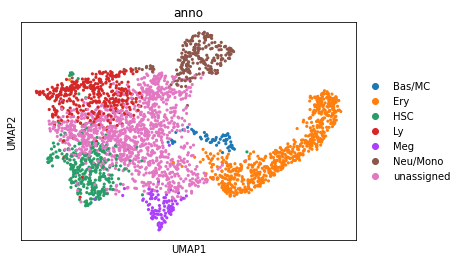

... storing 'ref_leiden' as categorical
... storing 'ref_anno' as categorical


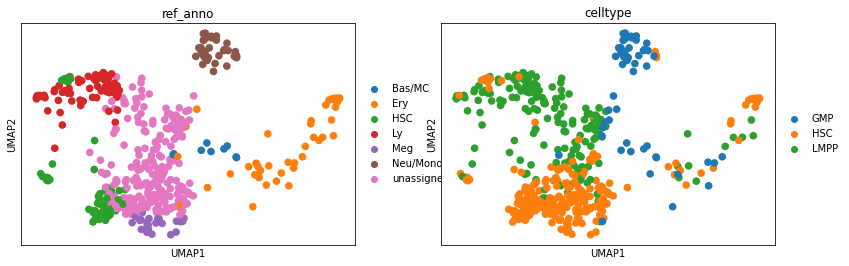

In [93]:
#Setting the Seurat-corrected values for the target data (data is already scaled)
target.X = comb_cor_unscaled[target.obs.index, target.var.index].X.copy()

#Setting fit_pca=True to fit the SS2 Seurat-corrected data into reference space
#Setting scale_data=True, to scale the target data - as the original UMAP is based on scaled data.
#project_cells uses the mean and sd columns from the ref.var attribute to scale the data
cp.project_cells(target, ref,
                 obs_columns=['leiden', 'anno'],
                 fit_pca=True,
                 scale_data=True,
                 umap_ref=umap_ref)

#Plotting reference landscape
sc.pl.umap(ref, color=['anno'])
#Plotting target data celltypes and transferred annotation
sc.pl.umap(target, color=['ref_anno', 'celltype'])

Seurat's batch correction clearly improves the downstream asymmetric integration and we cellproject sucessfuly fits corrected back into the original landscape.

### Other batch correction methods
Some correction methods modify both batches, which complicates asymmetric integration. Cellproject provides a solution to this problem. We utilise the corrected expression/PC space to identify the (hopefully more accurate) nearest neighbors between the target and reference data. Next we use NN-regression to predict how target cells should look like in the the original reference space. Finally, we use the predicted data to transfer cell annotation and fit into the original reference UMAP coordinates. We will demonstrate this process by using the **scanorama** batch correction but the same principle applies to other methods. While, in this particular case, scanorama performs worse than Seurat in integrating the data it will serve well to demonstrate the workflow.

First we correct the combined data with scanorama and store the PC values accordingly for subsequent use.

In [94]:
#We will reuse the combined data set (`comb`) from the previous section which contains log-normalised values for the target and reference.
#To run scarnoama we need to generate a common PC space, which will be corrected by scanorama.
sc.pp.scale(comb)
sc.pp.pca(comb, n_comps=20)
sce.pp.scanorama_integrate(comb, 'data_type', knn=20)

#We will need the original reference PCA coordinates later, making a copy.
ref.obsm['X_pca_backup'] = ref.obsm['X_pca'].copy()

#Re-assigning the corrected PC space to the 'X_pca' slot, which is used by cellproject
ref.obsm['X_pca'] = comb[ref.obs.index, ref.var.index].obsm['X_scanorama'].copy()
target.obsm['X_pca'] = comb[target.obs.index, target.var.index].obsm['X_scanorama'].copy()

/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


[[0.         0.94747082]
 [0.         0.        ]]
Processing datasets 10x <=> SS2


/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Now we identify the neighbors between the target and reference data (we are using the common, corrected PC space so setting `fit_pca=False`)


In [95]:
cp.project_cells(target, ref,
                 obs_columns=['leiden', 'anno'],
                 fit_pca=False,
                 scale_data=False)

No valid UMAP object provided, UMAP parameters left unmodified


Using the nearest neighbors we predict how each target cells should look like in the reference space. `nnregress` will predict the expression profile as well as the PCA coordinates (in the original reference space).

In [96]:
#We need to go back to original reference PCA coordinates
ref.obsm['X_pca'] = ref.obsm['X_pca_backup'].copy()

cp.nnregress(target,
             ref,
             regress=['X', 'pca'],
             weighted=True)

Finally we rerun `project_cells` which will reacalculate neighbors for the predicted target cells, transfer labels and embed into the reference UMAP

Using the provided UMAP reference to fit new data


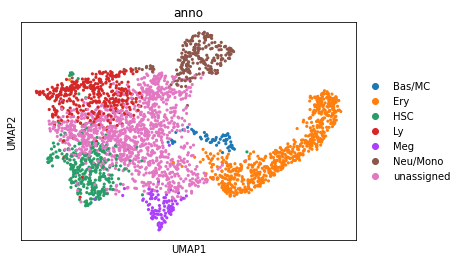

... storing 'ref_leiden' as categorical
... storing 'ref_anno' as categorical


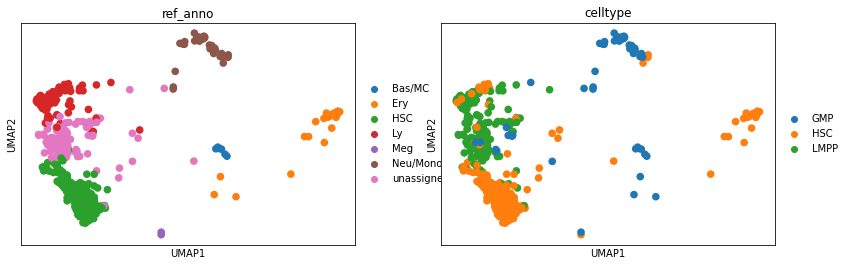

In [97]:
cp.project_cells(target, ref,
                 obs_columns=['leiden', 'anno'],
                 fit_pca=False,
                 scale_data=False,
                 umap_ref=umap_ref)

sc.pl.umap(ref, color=['anno'])
sc.pl.umap(target, color=['ref_anno', 'celltype'])

As we can see above cellproject works just fine downstream of other integration methods.